In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import EEGAnalysis as ea

In [34]:
example = "../Data/Yunfan Shu/EEG/EDF/15_3.edf"
%time k = ea.io.loadedf(example, "n.a.")

CPU times: user 160 ms, sys: 179 ms, total: 340 ms
Wall time: 338 ms


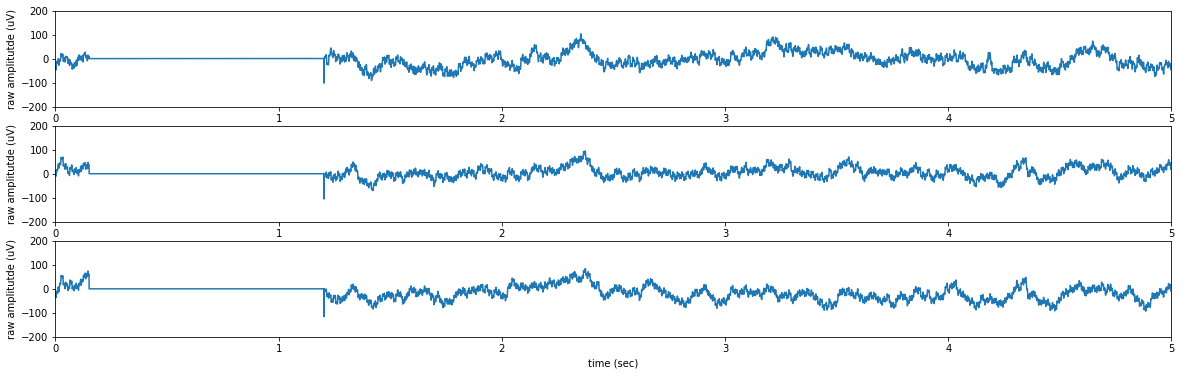

In [51]:
chidx = 90
plt.figure(figsize=(20,6))

plt.subplot(3,1,1)
plt.plot(k.tspec, k.physical_unit[chidx-1] * k.data[chidx-1,:])
plt.ylim(-200, 200)
plt.xlim([0,5])
plt.ylabel("raw amplitutde (uV)")
plt.xlabel("time (sec)")


plt.subplot(3,1,2)
plt.plot(k.tspec, k.physical_unit[chidx] * k.data[chidx,:])
plt.ylim(-200, 200)
plt.xlim([0,5])
plt.ylabel("raw amplitutde (uV)")
plt.xlabel("time (sec)")

plt.subplot(3,1,3)
plt.plot(k.tspec, k.physical_unit[chidx+1] * k.data[chidx+1,:])
plt.ylim(-200, 200)
plt.xlim([0,5])
plt.ylabel("raw amplitutde (uV)")
plt.xlabel("time (sec)")

plt.show()

CPU times: user 427 ms, sys: 43.3 ms, total: 470 ms
Wall time: 240 ms


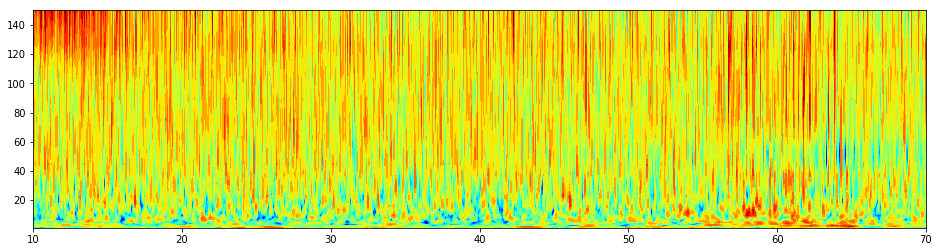

In [49]:
chidx = 90  # 选取目标的channel编号
trange = (10.0, 70.0)  # 设置目标的时间段，单位为sec，注意：不要超过实际数据的最大范围

starter = int(trange[0] * k.fs)
gap = int((trange[1]-trange[0]) * k.fs)
target_ch = k.data[chidx, starter:starter+gap] * k.physical_unit[chidx]  # 获取目标的原始数据片段

frange = np.logspace(np.log10(1), np.log10(150), 30)  # 设置目标的频率范围
%time dwt_result = ea.dwt.dwt(target_ch, int(k.fs), frange, reflection=False)  # 进行小波变换，这时由于片段时间足够长，边界效应可以忽略，reflection可设为False

pxx = ea.power.dwt_power(dwt_result, int(k.fs))  # 转化为power，并做zscore归一化处理

# 可视化
plt.figure(figsize=(16,4))
tspec = np.linspace(trange[0],trange[1], np.size(pxx, 1))
plt.contourf(tspec[::20], frange, pxx[:,::20], 40, cmap=plt.get_cmap("jet"))

plt.xlim(trange)  # 设置x轴的范围
plt.clim([-3,3])
plt.show()
plt.close()

In [2]:
from scipy.io import loadmat

In [3]:
a = loadmat("../Data/Chen Zhou/EEG/SgCh/ch001/180831-2-10_ch001.mat")

In [4]:
np.size(a["values"]) / 2000

222.0

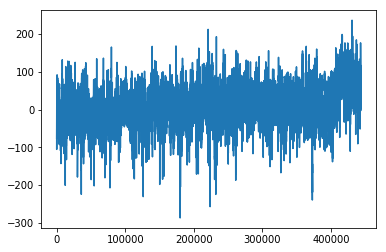

In [8]:
plt.plot(a["values"][0,:])